In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import glob
import random
from matplotlib import cm
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import numpy as np

In [3]:
# Diretório dos shapefiles
shapefiles_path = '/content/drive/MyDrive/PESQUISAS/ENSAIO_MUDANCAS_CLIMATICAS/SAIDA/04_MUNICIPIOS_IBGE/AGREGACAO_POR_SETOR/*.shp'

# Lista de shapefiles
files_list = glob.glob(shapefiles_path)

In [4]:
anos_selecionados = ['1997', '2003', '2010', '2015', '2023']


from textwrap import wrap

# Inicialização das variáveis
dados_totais = []


In [5]:
# Função para ler e processar os dados dos arquivos
def processar_dados(files_list, anos_selecionados):
    dados_totais = []

    for file in files_list:
        df = gpd.read_file(file)  # Ler arquivo shapefile
        setor = os.path.basename(file).replace('.shp', '').replace('_', ' ')  # Nome do setor
        df = df[['Municipio'] + anos_selecionados]  # Filtrar colunas relevantes

        # Calcular o ranking dos 5 maiores emissores por ano
        for ano in anos_selecionados:
            ranking = df[['Municipio', ano]].sort_values(by=ano, ascending=False).head(5)
            ranking['Setor'] = setor  # Adicionar a coluna do setor
            dados_totais.append(ranking)  # Adicionar dados ao total

    return pd.concat(dados_totais)  # Concatenar todos os rankings

# Função para quebrar o texto nas caixinhas em várias linhas, apenas em espaços
def wrap_text(text, width):
    words = text.split(' ')  # Dividir o texto em palavras
    lines = []
    current_line = ""

    for word in words:
        # Se adicionar a palavra exceder o limite de largura, adiciona a linha atual e começa uma nova
        if len(current_line + ' ' + word) > width:
            lines.append(current_line)
            current_line = word
        else:
            if current_line:  # Se já tiver texto na linha, adiciona a palavra com espaço
                current_line += ' ' + word
            else:
                current_line = word
    lines.append(current_line)  # Adicionar a última linha
    return lines

In [6]:
# Função para gerar cores aleatórias
def gerar_cores_unicas(num_cores):
    cores = []
    random.seed(42)  # Para garantir a reprodutibilidade das cores

    while len(cores) < num_cores:
        # Gerar uma cor aleatória com formato rgba
        cor_aleatoria = to_rgba(np.random.rand(4))  # RGBA com aleatoriedade
        # Garantir que a cor não seja repetida
        if cor_aleatoria not in cores:
            cores.append(cor_aleatoria)

    return cores

In [7]:
# Função para criar o gráfico
def criar_grafico(ranking_completo, anos_selecionados):
    # Gerar cores aleatórias únicas para cada município
    municipios_unicos = ranking_completo['Municipio'].unique()
    num_municipios = len(municipios_unicos)
    municipio_colors = {municipio: cor for municipio, cor in zip(municipios_unicos, gerar_cores_unicas(num_municipios))}

    for setor in ranking_completo['Setor'].unique():
        setor_df = ranking_completo[ranking_completo['Setor'] == setor]

        # Criar a figura com tamanho ajustado para (12, 6)
        plt.figure(figsize=(12, 6))

        # Gráfico
        for i, ano in enumerate(anos_selecionados):
            ax = plt.gca()

            # Filtra o ranking para aquele ano
            ranking_ano = setor_df[setor_df['Ano'] == ano].sort_values(by='Emissao', ascending=False).head(5)

            # Desenhar as caixinhas (retângulos) para os municípios
            for j, (municipio, emissao) in enumerate(zip(ranking_ano['Municipio'], ranking_ano['Emissao'])):
                # Quebra o texto em linhas de acordo com a largura máxima
                wrapped_text = "\n".join(wrap_text(municipio, 10))  # Limita a largura, mas só quebra nas palavras

                x_pos = i * 2  # Posição X, maior espaçamento entre os anos
                y_pos = 4 - j  # Ajuste para a posição 1 no topo e 5 na base

                # Desenha a caixinha com a cor associada ao município
                ax.add_patch(plt.Rectangle((x_pos, y_pos), 1.2, 0.8, color=municipio_colors[municipio]))  # Caixinha

                # Centralizar o texto na caixinha
                ax.text(x_pos + 1.2 / 2, y_pos + 0.8 / 2, wrapped_text, ha='center', va='center', color='black', fontsize=10)

        # Ajustar os eixos
        plt.xlim(-0.5, len(anos_selecionados) * 2 - 0.5)  # Ajustando a largura do eixo X para que as caixinhas fiquem visíveis
        plt.ylim(-0.5, 5)  # Garantir que todas as posições fiquem dentro do gráfico

        # Customizar eixos
        ax.set_xticks(np.arange(len(anos_selecionados)) * 2 + 0.6)
        ax.set_xticklabels(anos_selecionados)
        ax.set_yticks(np.arange(5))
        ax.set_yticklabels([f'Posição {i+1}' for i in range(5)][::-1])  # Inverter as posições no eixo Y para a Posição 1 ficar no topo

        # Adicionar título
        plt.title(f'Ranking de Emissões por Município no Setor: {setor}')
        plt.xlabel('Ano')
        plt.ylabel('Posição')

        plt.tight_layout()
        plt.show()

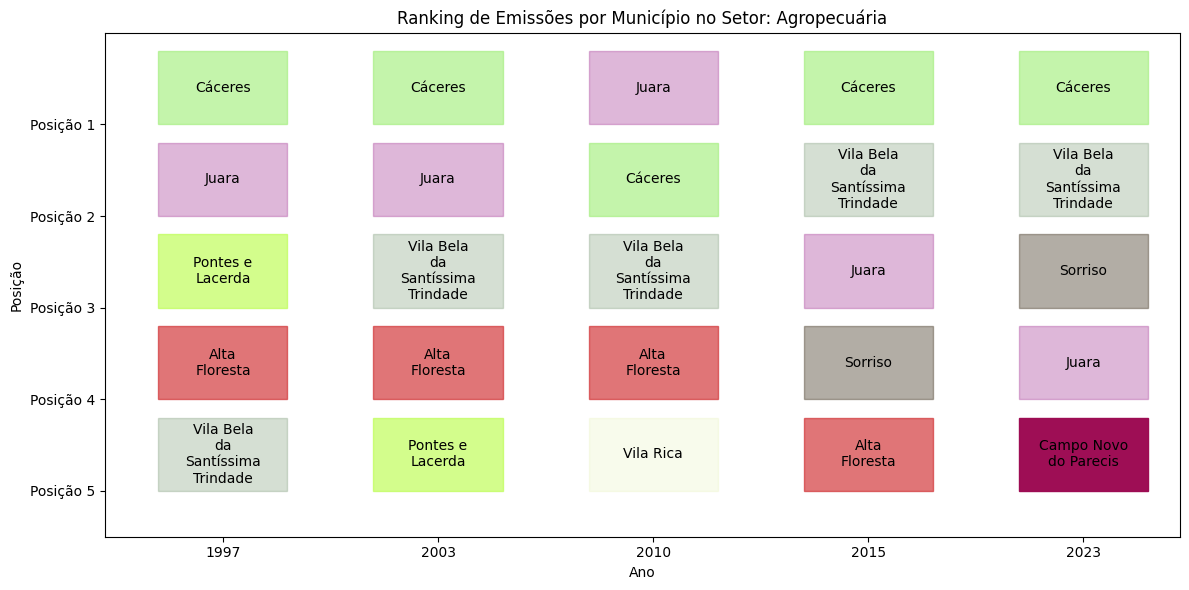

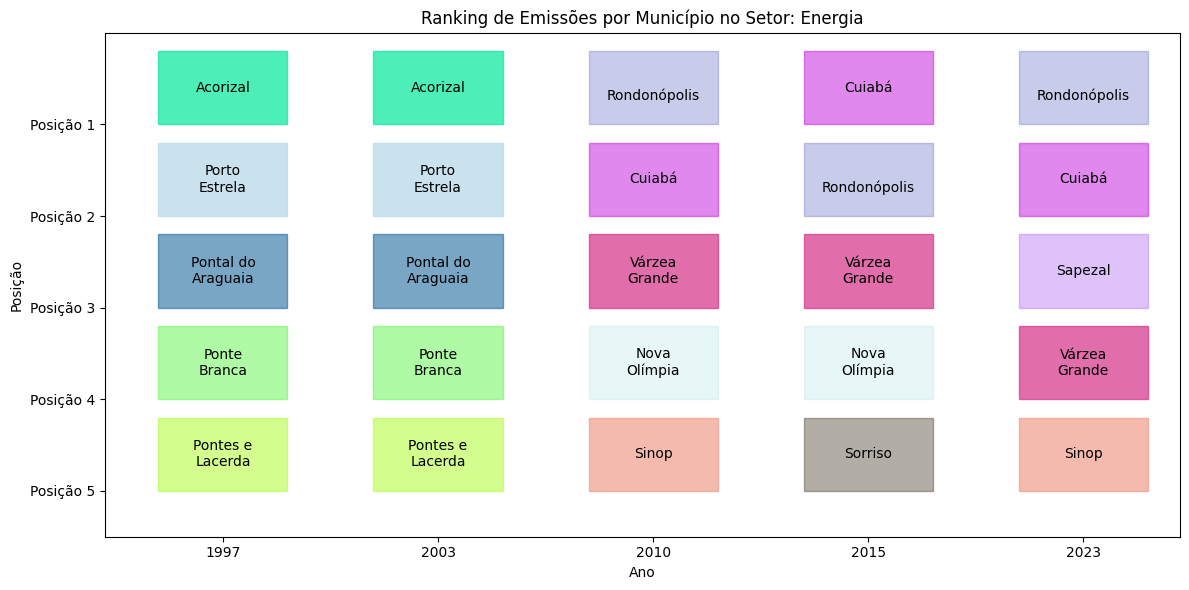

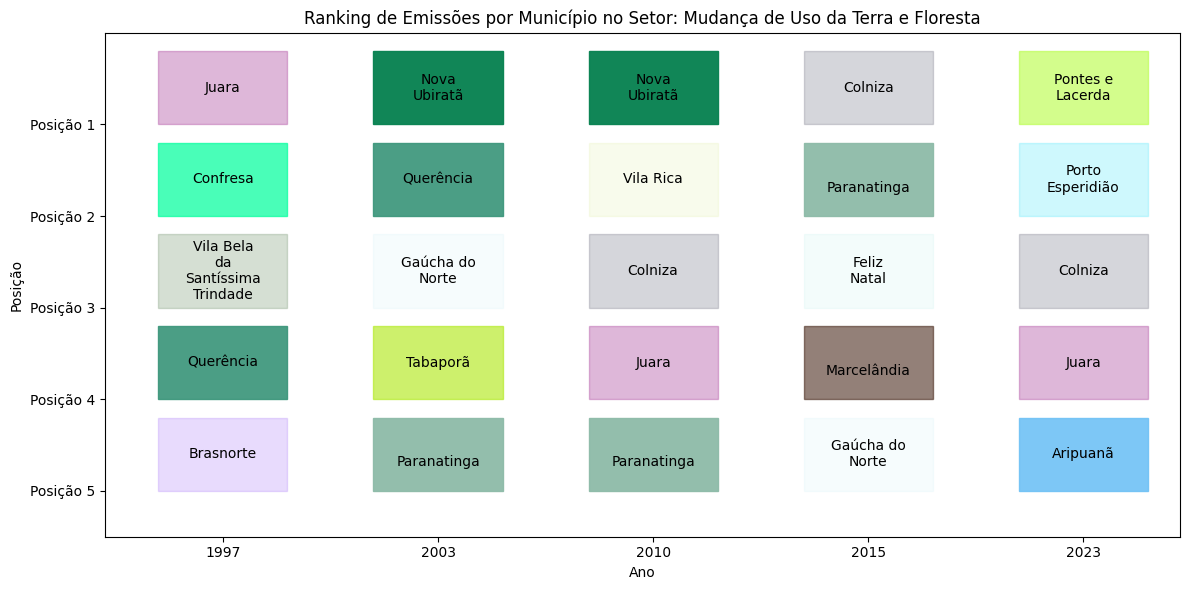

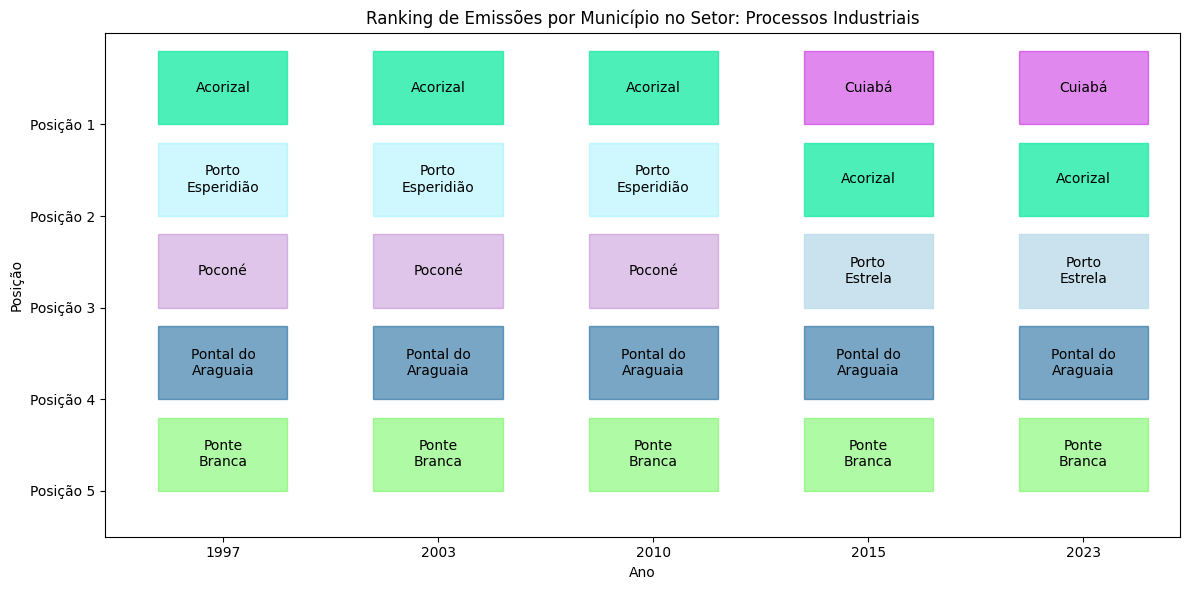

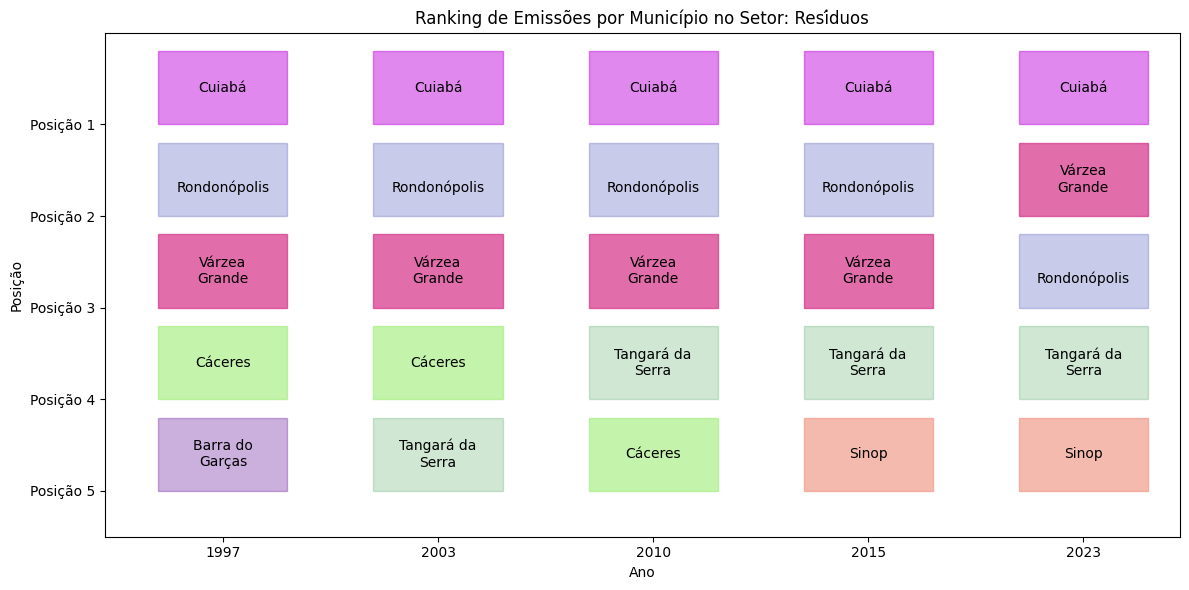

In [8]:
# Processar os dados e criar o gráfico
ranking_completo = processar_dados(files_list, anos_selecionados)
ranking_completo = pd.melt(ranking_completo, id_vars=["Municipio", "Setor"], value_vars=anos_selecionados,
                           var_name="Ano", value_name="Emissao")
criar_grafico(ranking_completo, anos_selecionados)